In [34]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.finance as mf
from matplotlib.dates import date2num

# ヒストリカルデータをCSVファイルから読み取り

In [35]:
csv=pd.read_csv('USDJPY60.csv',
                 sep=',',
                 names=('YY.MM.DD', 'HH:MM', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME'),
                 index_col=['YY.MM.DD', 'HH:MM'])

# データを日付でフィルタリング

In [36]:
data=csv # すべてのデータ
#data=csv['2017.02.01':'2017.02.09'] # 2017/2/1から2/9までのデータ
#data=csv['2016.09.01':'2016.10.31']
data

OPEN     HIGH      LOW    CLOSE  VOLUME
YY.MM.DD   HH:MM                                            
2016.08.05 22:00  101.738  101.813  101.733  101.753     615
           23:00  101.750  101.825  101.732  101.778    1091
2016.08.08 00:00  101.959  102.000  101.845  101.906    1652
           01:00  101.906  102.257  101.852  102.230    2419
           02:00  102.228  102.253  102.042  102.053    1374
           03:00  102.053  102.141  101.911  102.099    2308
           04:00  102.096  102.143  102.020  102.142    1296
           05:00  102.138  102.144  101.976  102.036     695
           06:00  102.037  102.069  101.926  102.011     730
           07:00  102.014  102.059  101.954  102.004     546
           08:00  102.000  102.083  101.983  102.072     639
           09:00  102.077  102.196  102.032  102.185     738
           10:00  102.182  102.306  102.102  102.291    1393
           11:00  102.288  102.328  102.212  102.277    1063
           12:00  102.278  102.454  102.246  102.396    1090
           13:00  102.400  102.431  102.310  102.330     900
           14:00  102.327  102.417  102.307  102.409     614
           15:00  102.413  102.488  102.388  102.483     876
           16:00  102.486  102.652  102.463  102.573    1275
           17:00  102.577  102.578  102.434  102.525    1324
           18:00  102.528  102.620  102.521  102.530     869
           19:00  102.528  102.568  102.494  102.568     202
           20:00  102.571  102.585  102.471  102.489     257
           21:00  102.492  102.500  102.358  102.478     421
           22:00  102.476  102.485  102.416  102.435     321
           23:00  102.438  102.464  102.426  102.447     239
2016.08.09 00:00  102.363  102.492  102.359  102.401    1210
           01:00  102.401  102.468  102.391  102.448     472
           02:00  102.447  102.447  102.268  102.283     752
           03:00  102.284  102.397  102.278  102.361    1090
...                   ...      ...      ...      ...     ...
2017.02.09 11:00  112.293  112.329  112.156  112.239    1184
           12:00  112.240  112.305  112.216  112.276     825
           13:00  112.278  112.436  112.254  112.362    1246
           14:00  112.361  112.472  112.284  112.355    1063
           15:00  112.352  112.462  112.251  112.403    2339
           16:00  112.404  112.843  112.231  112.769    3444
           17:00  112.770  113.194  112.719  112.979    6731
           18:00  112.982  113.298  112.939  113.252    3256
           19:00  113.255  113.264  113.063  113.146    1569
           20:00  113.145  113.254  113.037  113.132    1776
           21:00  113.131  113.331  113.093  113.307    1446
           22:00  113.310  113.347  113.223  113.239     804
           23:00  113.235  113.261  113.154  113.240     453
2017.02.10 00:00  113.237  113.350  113.215  113.289    1381
           01:00  113.290  113.469  113.247  113.432    1501
           02:00  113.430  113.740  113.394  113.694    2355
           03:00  113.695  113.800  113.629  113.663    1988
           04:00  113.662  113.754  113.624  113.654    1019
           05:00  113.652  113.695  113.547  113.682    1086
           06:00  113.686  113.786  113.616  113.690     874
           07:00  113.689  113.739  113.639  113.697     839
           08:00  113.700  113.787  113.692  113.716     717
           09:00  113.718  113.859  113.617  113.840    1754
           10:00  113.843  113.852  113.526  113.571    2032
           11:00  113.572  113.697  113.572  113.650    1613
           12:00  113.651  113.703  113.511  113.545    1162
           13:00  113.544  113.577  113.362  113.480    1383
           14:00  113.477  113.567  113.434  113.566    1307
           15:00  113.564  113.727  113.401  113.639    2171
           16:00  113.642  113.736  113.570  113.584    1601

[3185 rows x 5 columns]

In [5]:
# dates=[pd.to_datetime(i[0] + ' ' + i[1]) for i in data.index]

# データ整形
* dates[], op[], cl[], hi[], lo[]
    * 日付リスト, 始値リスト, 終値リスト, 最高値リスト, 最低値リスト
* candle[]
    * ローソク足チャート描画用データ (日付, 始値, 終値, 最高値, 最低値)

In [37]:
dates = []
candle = []
for i, v in data.iterrows():
    t = pd.to_datetime(i[0] + ' ' + i[1]);
    dates.append(t)
    candle.append((date2num(t), v['OPEN'], v['CLOSE'], v['HIGH'], v['LOW']))

In [38]:
op=data['CLOSE'].tolist()
cl=data['CLOSE'].tolist()
hi=data['HIGH'].tolist()
lo=data['LOW'].tolist()

# MACD

1時間足の終値 `cl[]` を使用してMACDを計算

In [39]:
def ema(l, t):
    result = []
    for p in l:
        i = len(result)
        if i < t: # t日目までは単純平均
            result += [float(sum(result) + p) / (i + 1)]
        else:
            last = result[-1]
            result += [last + 2. * (p - last) / (t + 1)]
    return result

In [40]:
prices = cl
ema12 = np.array(ema(prices, 12))
ema24 = np.array(ema(prices, 24))
macd = ema12 - ema24
signal = np.array(ema(macd, 9))

# ローソク足チャート, MACD描画

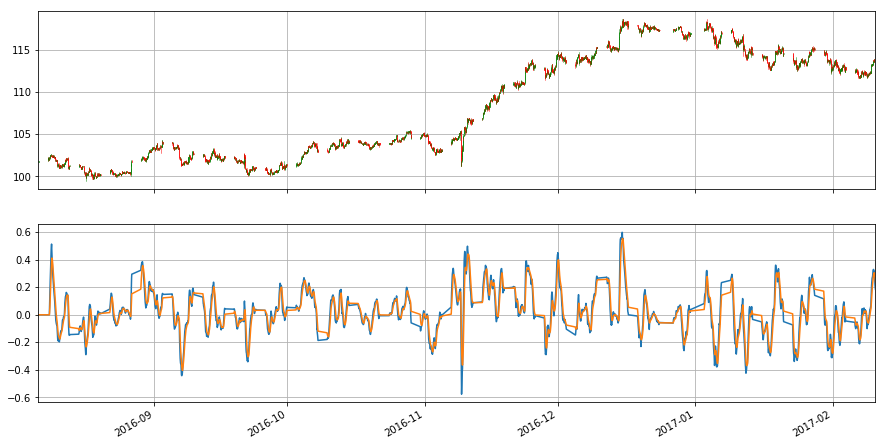

In [20]:
fig = plt.figure(figsize=(15, 8))

# candle chart
ax = fig.add_subplot(211)
ax.grid()
ax.set_xlim(dates[0], dates[-1])
mf.candlestick_ochl(ax, candle, width=0.02, colorup='g', colordown='r', alpha=0.75)
fig.autofmt_xdate()

# MACD
ax = fig.add_subplot(212)
ax.grid()
ax.set_xlim(dates[0], dates[-1])
ax.plot(dates, macd)
ax.plot(dates, signal)
fig.autofmt_xdate()

# SignalとMACDの差分を描画

`(signal-MACD)=0.0`のポイントが、signalとMACDがクロスしたポイントである。

In [41]:
diff = signal - macd

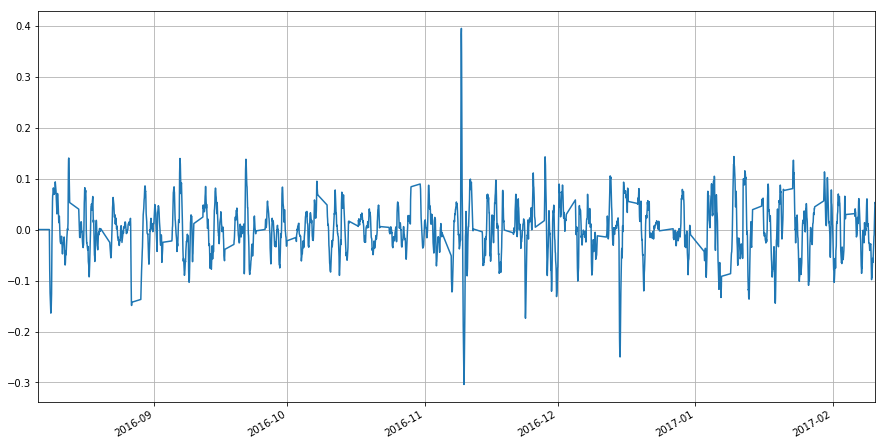

In [42]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(111)
ax.grid()
ax.set_xlim(dates[0], dates[-1])
ax.plot(dates, diff)
fig.autofmt_xdate()

# SignalとMACDのクロスを利用した売買シミュレーション (1)

* SignalとMACDのクロスを、買いシグナルと売りシグナルとして用いる。

* シグナルでポジションを建てて、次のシグナルで決済した場合のプロフィットを計算する。

In [44]:
skip = True
position = 0
profit = []
for i in range(len(diff)):
    if skip==True and diff[i]==0:
        continue
    elif skip==True:
        flag = True if diff[0] > 0 else False
        skip = False
        continue
    if flag==True and diff[i] < 0:
        #print "買いシグナル %s %f %f" % (dates[i], prices[i], position - prices[i])
        if position != 0:
            profit.append(position - prices[i])
        position = prices[i]
        flag = False
    elif flag==False and diff[i] > 0:
        #print "売りシグナル %s %f %f" % (dates[i], prices[i], prices[i] - position)
        if position != 0:
            profit.append(prices[i] - position)
        position = prices[i]
        flag = True

unit = 1
print "%d trades" % len(profit)
print "profit total %f average %f min %f max %f" % (sum(profit)*unit, sum(profit)*unit/len(profit), min(profit)*unit, max(profit)*unit)

230 trades
profit total 15.320000 average 0.066609 min -1.264000 max 2.559000


* 1回のトレードで1通貨(1ドル)の取引とする。
* 1トレードあたり平均0.0666円の利益が出た。
* 最も良いときで2.559円の利益が出た。
* 最も悪いときで-1.264円の損失が出た。
* トータルでは15.32円の利益が出た。

# SignalとMACDのクロスを利用した売買シミュレーション (2)

* SignalとMACDのクロスを、買いシグナルと売りシグナルとして用いる。

* シグナルでポジションを建て、次のシグナルまでの間に最も利益を出す（最も損失を少なくする）ポイントで決済できたと仮定した場合のプロフィットを計算する。

In [47]:
skip = True
position = []
profit = []
for i in range(len(diff)):
    #print "%s open %f close %f high %f low %f" % (dates[i], op[i], cl[i], hi[i], lo[i])
    if skip==True and diff[i]==0:
        continue
    elif skip==True:
        flag = True if diff[0] > 0 else False
        skip = False
        continue
    if len(position)==2:
        #現ポジションを評価
        v=0
        if flag==True:
            #売りポジション
            v=position[0]-lo[i]
        else:
            #買いポジション
            v=hi[i]-position[0]
        if position[1] < v:
            if v>0:
                print "profit gain %f" % v
            else:
                print "profit loss %f" % v
            position[1] = v
    if flag==True and diff[i] < 0:
        #現ポジション結果保存
        if len(position)==2:
            profit.append(position[1])
        #新規ポジション
        #print "買い"
        position = [prices[i], -99999] #[買ポジション価格, 最大益]
        flag = False
    elif flag==False and diff[i] > 0:
        #前ポジション結果保存
        if len(position)==2:
            profit.append(position[1])
        #新規ポジション
        #print "売り"
        position = [prices[i], -99999] #[売ポジション価格, 最大益]
        flag = True

unit = 1
print "%d trades" % len(profit)
print "profit total %f average %f min %f max %f" % (sum(profit)*unit, sum(profit)*unit/len(profit), min(profit)*unit, max(profit)*unit)

profit gain 0.010000
profit gain 0.133000
profit gain 0.251000
profit gain 0.369000
profit gain 0.470000
profit gain 0.594000
profit gain 0.603000
profit gain 0.616000
profit gain 1.147000
profit gain 1.202000
profit gain 1.246000
profit gain 1.280000
profit gain 1.351000
profit gain 1.432000
profit gain 1.436000
profit gain 0.064000
profit gain 0.098000
profit gain 0.204000
profit gain 0.223000
profit gain 0.393000
profit gain 0.663000
profit gain 0.773000
profit gain 0.924000
profit gain 0.030000
profit gain 0.090000
profit gain 0.092000
profit gain 1.173000
profit gain 1.260000
profit gain 0.011000
profit gain 0.119000
profit gain 0.203000
profit gain 0.087000
profit gain 0.132000
profit gain 0.142000
profit gain 0.373000
profit gain 0.555000
profit gain 0.672000
profit gain 0.762000
profit gain 0.822000
profit gain 1.049000
profit gain 1.087000
profit gain 1.386000
profit gain 0.062000
profit gain 0.233000
profit gain 0.487000
profit gain 0.712000
profit gain 0.096000
profit gain 0

* 1回のトレードで1通貨(1ドル)の取引とする。
* 1トレードあたり平均0.54773円の利益が出た。
* 最も良いときで3.509円の利益が出た。
* 最も悪いときで-0.093円の損失が出た。
* トータルでは125.978円の利益が出た。

10000通貨なら5477.3円の利益。

10000通貨で230回トレードすれば、1,259,779円の利益。

In [25]:
average = sum(profit)*unit/len(profit)
n = len(filter(lambda x: x > average, profit))
print "average %f good trade %d profit %f" % (average, n, average*n)

average 0.547730 good trade 81 profit 44.366165


* 1トレードあたりの平均利益0.54773円を上回る利益を出せたトレードは、230トレード中、81トレードだった。
* 決済ルールを **0.54773円の利益が出たら決済** とすると、その81トレードだけで、44.366165円の利益を出せた。
* 残りの149トレードの決済ルールを **次のシグナルが来たら決済** とするとどうなるか。

In [26]:
skip = True
rule = 0.54773 # プロフィットがこれを超えたら決済せよ
position = []
profit = []
for i in range(len(diff)):
    print "%s open %f close %f high %f low %f" % (dates[i], op[i], cl[i], hi[i], lo[i])
    if skip==True and diff[i]==0:
        continue
    elif skip==True:
        flag = True if diff[0] > 0 else False
        skip = False
        continue
    if len(position)==2 and position[1]==False: #現ポジションが未決済か?
        #現ポジションを評価
        v=0
        if flag==True:
            #売りポジション
            v=position[0]-lo[i]
        else:
            #買いポジション
            v=hi[i]-position[0]
        if rule < v:
            #現ポジション結果保存
            profit.append(rule) # ruleの価格で決済
            position[1]=True # 決済済み
            print "fixed profit %f" % profit[-1]
    if flag==True and diff[i] < 0:
        #新規ポジション
        if len(position)==2 and position[1]==False:
            profit.append(position[0]-prices[i])
            print "fixed profit %f" % profit[-1]
        print "買い"
        position = [prices[i], False] #[買ポジション価格, 未決済]
        flag = False
    elif flag==False and diff[i] > 0:
        #前ポジション結果保存
        if len(position)==2 and position[1]==False:
            profit.append(prices[i]-position[0])
            print "fixed profit %f" % profit[-1]
        #新規ポジション
        print "売り"
        position = [prices[i], False] #[売ポジション価格, 未決済]
        flag = True

unit = 1
print "%d trades" % len(profit)
print "profit total %f average %f min %f max %f" % (sum(profit)*unit, sum(profit)*unit/len(profit), min(profit)*unit, max(profit)*unit)

2016-08-05 22:00:00 open 101.753000 close 101.753000 high 101.813000 low 101.733000
2016-08-05 23:00:00 open 101.778000 close 101.778000 high 101.825000 low 101.732000
2016-08-08 00:00:00 open 101.906000 close 101.906000 high 102.000000 low 101.845000
2016-08-08 01:00:00 open 102.230000 close 102.230000 high 102.257000 low 101.852000
2016-08-08 02:00:00 open 102.053000 close 102.053000 high 102.253000 low 102.042000
2016-08-08 03:00:00 open 102.099000 close 102.099000 high 102.141000 low 101.911000
2016-08-08 04:00:00 open 102.142000 close 102.142000 high 102.143000 low 102.020000
2016-08-08 05:00:00 open 102.036000 close 102.036000 high 102.144000 low 101.976000
2016-08-08 06:00:00 open 102.011000 close 102.011000 high 102.069000 low 101.926000
2016-08-08 07:00:00 open 102.004000 close 102.004000 high 102.059000 low 101.954000
2016-08-08 08:00:00 open 102.072000 close 102.072000 high 102.083000 low 101.983000
2016-08-08 09:00:00 open 102.185000 close 102.185000 high 102.196000 low 102

* 1トレードあたり平均0.032422円の利益が出た。
* 最も良いときで0.54773円の利益が出た。
* 最も悪いときで-1.264円の損失が出た。
* トータルでは7.45713円の利益が出た。

10000通貨なら324.22円の利益。

10000通貨で230回トレードすれば、74,571.6円の利益。ちょっと寂しい。

# 検討事項

* **0.54773円の利益が出ないトレード**の決済ルールを洗練させる必要あり。

* シグナル発生時の状態（出来高や前シグナルとの高低差）と利益の間に相関関係がないだろうか?

* リアルタイムのデータを取るにはどうすれば?

# 検討(1) 0.54773円の利益が出ないトレードの決済ルール

* 前回は、0.54773円の利益が出たら決済、出なかったら次のシグナルで決済、というルールにした。

* ある程度で損切りするルールを追加しないと、損失が大きくなってしまう。

* そこで過去のトレードから利幅の平均を求め、その利幅のボトムを下回ったら損切りするルールを考えてみる。

* つまり、SignalとMACDのクロスでx円の買いポジションを建て、そこから次のクロスまでの間の値動きの中で、最も値が上ったときでx+0.5円、最も値が下がったときでx-0.1円とすると、利幅は-0.1〜0.5である。

* この利幅の下限の平均値を下回ったら損切りするルールとする。

# SignalとMACDのクロスを利用した売買シミュレーション (3)

* SignalとMACDのクロスを、買いシグナルと売りシグナルとして用いる。

* シグナルでポジションを建て、次のシグナルまでの期間での利幅 `lower ~ upper` を得る。

* 複数のトレードから`upper, lower` の平均値 `Eu, El` を求める。

* 評価益が `upper` を上回るか、評価損が `lower` 下回るか、次のシグナルが発生したとき決済するルールとする。

* `upper` の利益を得られるトレードの発生確率 `Pu`、`lower` の損失が発生するトレードの発生確率 `Pl` を計算する。

* `upper` と `lower` の間でうろうろしたトレードの発生確率は `1-(Pu+Pl)` となる。

* うろうろしたトレードの損益はトータルで0だったと仮定する。

* トレード数を多くすれば、プロフィットの期待値は `Pu * Eu + Pl * El` と考えることができるのではないだろうか。

In [86]:
skip = True
position = []
upper = []
lower = []
for i in range(len(diff)):
    #print "%s open %f close %f high %f low %f" % (dates[i], op[i], cl[i], hi[i], lo[i])
    if skip==True and diff[i]==0:
        continue
    elif skip==True:
        flag = True if diff[0] > 0 else False
        skip = False
        continue
    if len(position)==3:
        #現ポジションを評価
        u=0
        l=0
        if flag==True:
            #売りポジション
            u=position[0]-lo[i]
            l=position[0]-hi[i]
        else:
            #買いポジション
            u=hi[i]-position[0]
            l=lo[i]-position[0]
        if position[1] < u:
            position[1] = u
        if position[2] > l:
            position[2] = l
    if flag==True and diff[i] < 0:
        #現ポジション結果保存
        if len(position)==3:
            upper.append(position[1])
            lower.append(position[2])
        #新規ポジション
        #print "買い"
        position = [prices[i], -99999,99999] #[買ポジション価格, 最大益,最大損]
        flag = False
    elif flag==False and diff[i] > 0:
        #前ポジション結果保存
        if len(position)==3:
            upper.append(position[1])
            lower.append(position[2])
        #新規ポジション
        #print "売り"
        position = [prices[i], -99999,99999] #[売ポジション価格, 最大益,最大損]
        flag = True

unit = 1
print "%d trades" % len(upper)
average=sum(upper)/len(upper)
n=len(filter(lambda x: x > average, upper))
p=1.0*n/len(upper)*100
profit=average*n
print "upper average %f good trade %d (%.1f%%)" % (average, n, p)
average=sum(lower)/len(lower)
n=len(filter(lambda x: x < average, lower))
p=1.0*n/len(lower)*100
profit+=average*n
print "lower average %f bad trade %d (%.1f%%)" % (average, n, p)
print "expected profit %f" % profit

230 trades
upper average 0.547730 good trade 81 (35.2%)
lower average -0.297057 bad trade 88 (38.3%)
expected profit 18.225191


* 例えば1トレードでの取引通貨単位を10000通貨とする。

* 35.2%の確率で1トレードあたり5477.3円の利益、38.3%の確率で1トレードあたり2970.57円の損失、残り27%のトレードは損益がほぼ0。

* 1トレードの期待値は、`5477.3*0.35217-2970.57*0.38260=790.4円`

* 230回トレードでの期待値は、`790.4*230=182252円`

前回が1トレードあたり利益324.22円だったので倍に増えた。